# Predicting Pet Insurance Claims - Exploratory Data Analysis

## 1 Introduction

### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future. 

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy. 

### 1.3 Initial Questions for EDA
Below are a few initial questions to answer and areas of interest for the detailed data analysis.
* What patterns or relationships exist between species and our other features?
* What is the distribution of our claims amounts by year? By breed? By species? By Age?
* Does enroll path matter when it comes to claims amounts?

Let's get started by importing the data we cleaned up in the data wrangling notebook.

## 2 Setup

### 2.1 Imports

In [197]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

### 2.2 Data Load & Preview

In [2]:
# Read in the data file generated during data wrangling
df = pd.read_csv('../data/merged_pets.csv')

# Preview
df.head(7).T

,0,1,2,3,4,5,6
PetId,0,1,2,3,4,5,6
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4
Deductible,200,500,500,500,700,700,250
EnrollPath,Web,Phone,Phone,Phone,Web,Phone,Web
AgeYr1,3,0,0,0,0,2,0
YoungAge,0,0,0,0,0,0,0
MixedBreed,0,0,1,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0


In [3]:
df.shape

(50000, 18)

### 2.3 Data Wrangling Summary 
Before we get started on the analysis, let's take a moment to recap what we've learned so far and what the data looks like.

#### 2.3.1 What do we know? 
* **Shape** - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* **Basic Info** - For each pet, we have some basic info including species, breed, age at time of enrollment and enroll path.
* **Policy Info** - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* **Claims Data** - We also have claims data for each pet covering the first two policy years including:
    * Number of claims per year and total (years 1 and 2 combined)
    * Average claim amount per year and total (years 1 and 2 combined) 
    * Amount of claims per year and total (years 1 and 2 combined)
* **New Columns** - Finally, we have a couple of columns we generated during data wrangling to capture specific aspects of the data. These include:
    * YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
    * MixedBreed - Designation for pets classified as some sort of *mixed* breed

#### 2.3.2 Initial Observations
* **Species** - We have two species of pets, Cats and Dogs
* **Breed** - We have 373 unique breeds in total (55 cat and 318 dog)
* **Age** - The age range is between 0 (i.e., < 1 year) and 13
* **Premium** - Premiums fall into a wide range with a few outlier values close to \\$1000
* **Deductible** - Deductibles are fairly well distributed and appear to be stratified across a range of common values.
* **Claims** 
    * For cats and dogs, the median value for total number and total amount of claims is 0.
    * On the flip side, both species have some significant outliers in both categories (number and amount of claims)
    
Now that we have a bit more context, let's jump in to the analysis.

## 3 Data Analysis
As a first step, we'll look at our count of pets per species. With that as our jumping off point, we can start investigating the first question from the intro... What patterns or relationships exist between species and our other features?

### 3.1 What is the count of pets per species?

In [4]:
df.Species.value_counts()

Dog    41976
Cat     8024
Name: Species, dtype: int64

As observed in data wrangling, we have approximately 50,000 pets in our data, roughly 85% of which are dogs. The remaining 15% are cats, so that keeps things fairly simple as we only have two breeds to compare. 

**But why do we see such a big discrepency in the number of dogs vs. the number of cats?**

It could mean that dogs are a more popular option for a pet, or it could mean that dogs are more expensive to keep healthy and insurance is needed. Intuitively, that should mean that dog owners have higher total claims amounts or a higher number of claims than cat owners on a per pet basis. 

Let's take a look.

### 3.2 Do dogs have higher claims or more claims than cats?
Based on what we observed in data wrangling, we know there are some very significant outliers in terms of claims amounts that will affect the interpretability of our plots. Let's filter down to a smaller range and take a look at the data.

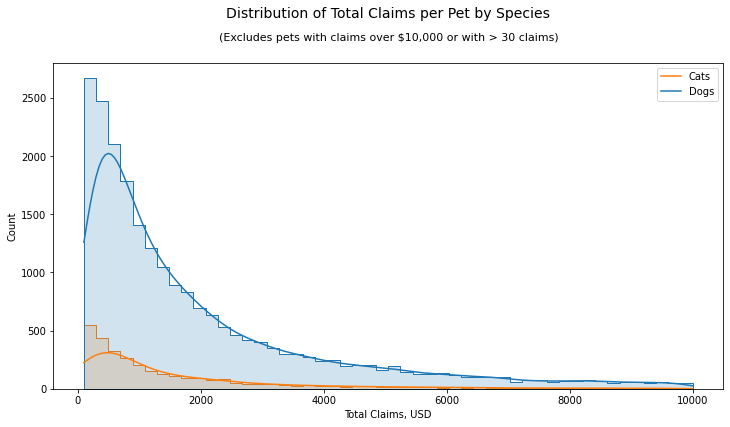

In [5]:
# Filter out outliers for number of claims and claim amounts
claim_filter = df[(df.AmtClaimsTotal < 10000) & (df.AmtClaimsTotal > 100) &
                 (df.NumClaimsTotal < 30) & (df.NumClaimsTotal > 0)]

# Create a histogram showing total claims by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="AmtClaimsTotal", data=claim_filter, hue='Species', alpha=0.2,
             element='step', kde=True, bins=50).set(title="Distribution of Total Claims, by Species",
                                          xlabel="Total Claims, USD")

# Plot legend and display
plt.title("Distribution of Total Claims per Pet by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.show()

The distributions for claims amounts per pet look somewhat similar, both spike on the low end and have long tails to the right. It does appear that the distribution for dogs is shifted somewhat further to the right overall but difficult to tell in this view.

Let's see if the number of claims is any different.

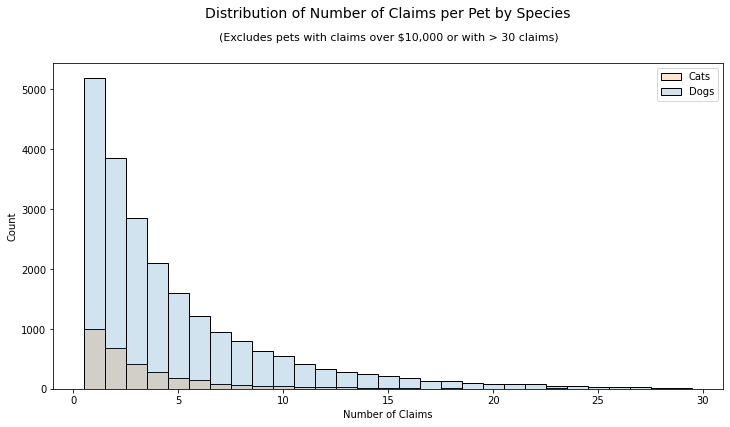

In [6]:
# Create a histogram showing number of claims per pet by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="NumClaimsTotal", data=claim_filter, hue='Species', alpha=0.2,
             element='bars', bins=30, discrete=True).set(xlabel="Number of Claims")

# Plot legend and display
plt.title("Distribution of Number of Claims per Pet by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.show()

Again, there doesn't seem to be an obvious story in the plot above and it's hard to see much difference in species when it comes to claims. Let's try one more plot before moving on to see  

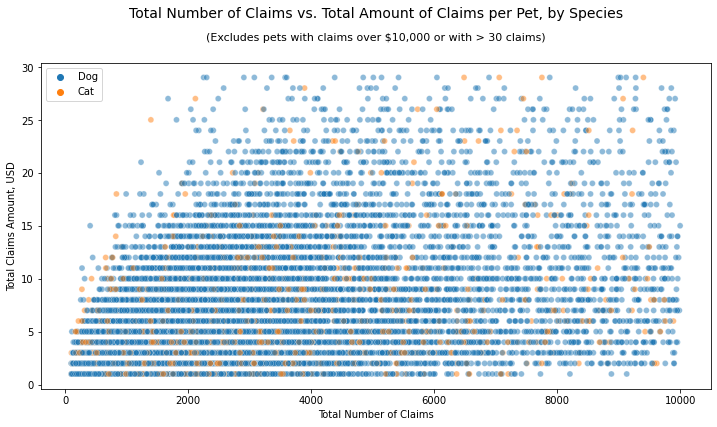

In [13]:
# Create a scatterplot showing Number of Claims vs Amount of Claims per pet by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter, hue="Species", 
                alpha=0.5).set(title="",
                               xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")

# Plot legend, add title, and display
plt.title("Total Number of Claims vs. Total Amount of Claims per Pet, by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='upper left')
plt.show()

The scatterplot is still inconclusive when grouping the species together. Let's try separating Cats and Dogs and adding a regression line to the data as a next step.

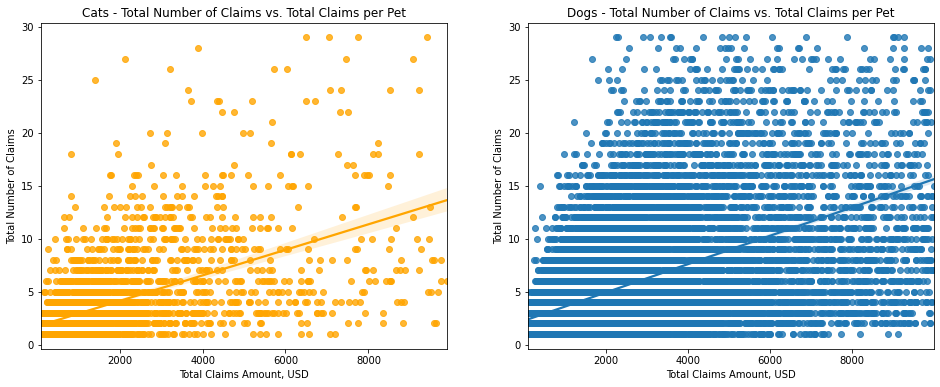

In [15]:
# Create regplots showing number of claims vs total claims amount by species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter[claim_filter.Species == 'Cat'],  
                ax=ax1, color="Orange"
                ).set(title="Cats - Total Number of Claims vs. Total Claims per Pet",
                     xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter[claim_filter.Species == 'Dog'],  
                ax=ax2).set(title="Dogs - Total Number of Claims vs. Total Claims per Pet", 
                            xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")

plt.show()

Interesting! We still don't see much difference in species when it comes to total amount of claims or total number of claims per pet. Based on this alone, we could make a case that dropping species from the data makes sense. But before we go that far, let's take a look at Premiums and Deductibles across species.  

**Conclusion**

Species does not appear to be much of a factor in predicting claims amounts.

### 3.3 Do dogs cost more to insure?

So our initial hypothesis - that dogs have higher claims amounts or more claims than cats - does not appear to be the case (at least not in a significant way). Based on this, we would expect to see similar premiums and deductibles across our species, but can we see that in the data?

In data wrangling, we observed some pets with very high premiums that will undoubtedly skew our analysis. Let's start by filtering down to a smaller range and then take a look at our distributions.

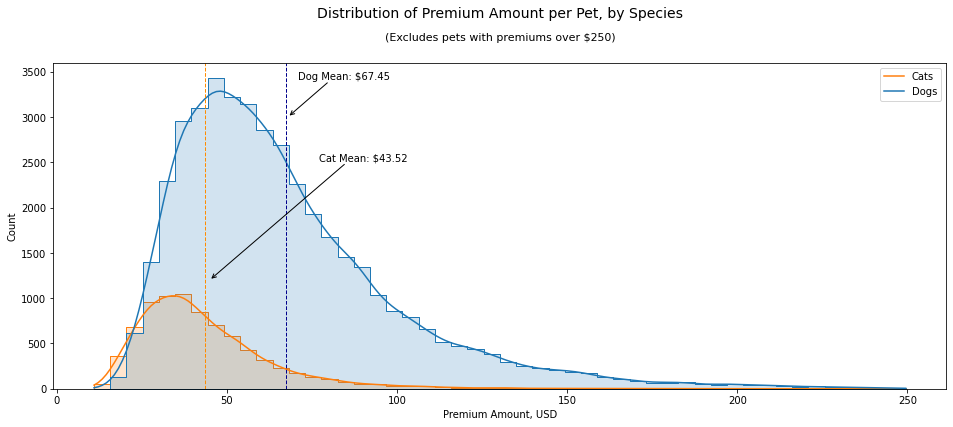

In [38]:
# Filter out the outlier premiums
prem_filter = df[df.Premium < 250][['Premium', 'Deductible', 'Species', 'AgeYr1']]
dog_mean = prem_filter[prem_filter.Species == 'Dog']['Premium'].mean()
cat_mean = prem_filter[prem_filter.Species == 'Cat']['Premium'].mean()

# Create a histogram showing premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.histplot(x="Premium", data=prem_filter, hue="Species", alpha=0.2,
             element='step', bins=50, kde=True).set(title="", xlabel="Premium Amount, USD")

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(cat_mean*1.77, max_ylim*0.7, 'Cat Mean: ${:.2f}'.format(cat_mean))
ax.annotate("", xy=(45, 1200), xytext=(85, 2490), arrowprops=dict(arrowstyle="->"))

plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(dog_mean*1.05, max_ylim*0.95, 'Dog Mean: ${:.2f}'.format(dog_mean))
ax.annotate("", xy=(68, 3000), xytext=(80, 3390), arrowprops=dict(arrowstyle="->"))

# Add title and display clot
plt.title("Distribution of Premium Amount per Pet, by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with premiums over $250)", y=0.95, x=0.513, fontsize=11)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.show()

Once again, looking at the premium distribution curves we see similar trends for both species but with dogs shifted further to the right. By adding the mean premium values, it's clear that dog owners do pay higher premiums *on average* when compared to cats. 

How does this trend affect deductible amounts? If dog owners pay higher premiums, then potentially they should have lower deductibles. Rather than plotting a distribution, let's look at a scatterplot of Premium vs. Deductible to see if any noticeable trends stand out.

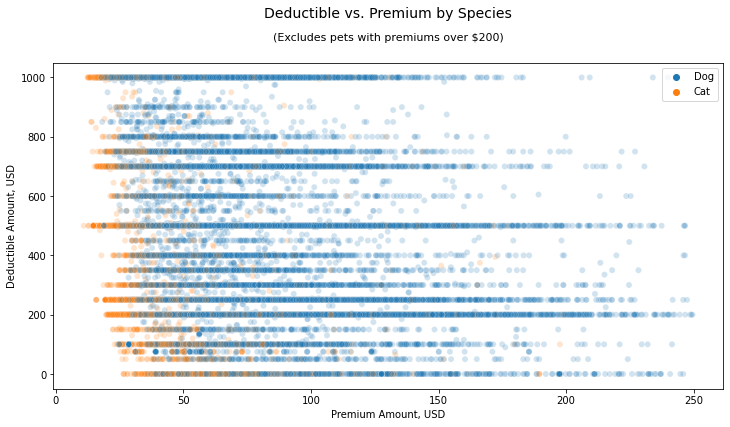

In [39]:
# Create a scatterplot showing deductible vs premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(y="Deductible", x="Premium", data=prem_filter, hue="Species", 
                alpha=0.2).set(title="", ylabel="Deductible Amount, USD", xlabel="Premium Amount, USD")

# Add title and display plot
plt.title("Deductible vs. Premium by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with premiums over $200)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='upper right')
plt.show()

In [40]:
# Display the mean deductible per species
dog_mean = df[df.Species == 'Dog']['Deductible'].mean()
cat_mean = df[df.Species == 'Cat']['Deductible'].mean()
print("Mean Deductible Amounts by Species (full dataset)")
print('Cat Mean Deductible: ${:.2f}'.format(cat_mean))
print('Dog Mean Deductible: ${:.2f}'.format(dog_mean))

Mean Deductible Amounts by Species (full dataset)
Cat Mean Deductible: $433.97
Dog Mean Deductible: $506.69


For deductible, we see a similar striation of the data for both dogs and cats at round number values (250, 500, 750), but it seems clear that cats tend to be bunched on the low end of the spectrum across the range. This trend is confirmed by looking at the mean values for our unfiltered dataframe where we see that dogs do have higher deductibles by ~\\$75 on average. So we are starting to see a picture here that *generally*, dogs are more expensive than cats (at least when it comes to insurance payments). 

**Conclusions**

* Dogs and cats both have a broad range of premiums and deductibles with similar distributions for each 
* On average, dogs have higher premiums and higher deductibles than cats

### 3.4 How many pets have claims in one or both years?
So far in EDA, we've seen that there isn't much of a difference in the distributions of the total number of claims across species. We've also observed both in EDA and data wrangling, that a significant number of pets have no claims at all within the first two years. 

**But what trends do we see for pets with claims in one or both years?** 
* Do the majority have claims in both years or only one year? 
* Additionally, are there any patterns that jump out when we look at pets with claims in both years in terms of species or age?

First, let's create a basic function to determine for each pet, if they have no claims, claims in one year (either year 1 or year 2), or claims in both years. Then we can plot our results to see if anything interesting jumps out.

In [41]:
# Create function to populate new column as count of number of years with claims (0, 1, 2)
def claim_yrs(row):
    if (row["NumClaimsTotal"] == 0):
        return 0
    elif ((row["NumClaimsYr1"] > 0) & (row["NumClaimsYr2"] > 0)):
        return 2
    else:
        return 1

# Apply function to df to create new column
df["YrsWithClaims"] = df.apply(claim_yrs, axis=1)

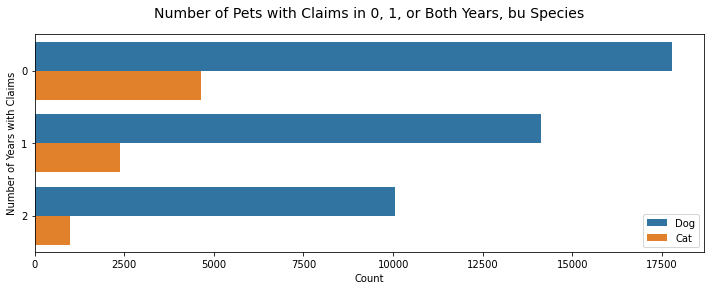

In [43]:
# Plot the count of pets with claims in 0, 1 or both years
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(y='YrsWithClaims', data=df, hue="Species").set(xlabel="Count",
                                                             ylabel="Number of Years with Claims")

# Add title and display plot
plt.title("Number of Pets with Claims in 0, 1, or Both Years, bu Species", y=1.05, fontsize=14)
# plt.suptitle("(Excludes pets with premiums over $200)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='lower right')
plt.show()

As noted earlier, the majority of pets in our data (and for each species) have no claims at all in the two years included in the dataset. Again, we see similar looking trends between species in terms of the counts at 0, 1 and 2 years, but it's hard to make out any differences since the dataset is unbalanced toward dogs by nearly 6 to 1. 

Let's see if plotting this based on the percentage of each species with claims in 0, 1 or 2 years highlights any differences. 

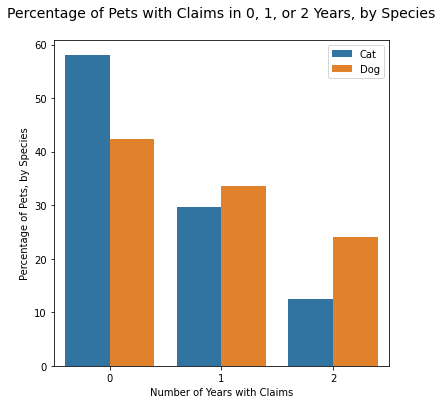

In [46]:
# Calculate the percentage of each species with claims in 0,1, or 2 years
claim_yr_counts = (df.groupby(['Species'])['YrsWithClaims']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('YrsWithClaims'))

# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(x="YrsWithClaims", y="Percentage", hue="Species", data=claim_yr_counts 
           ).set(xlabel="Number of Years with Claims", ylabel="Percentage of Pets, by Species")

# Plot the legend and display
plt.title("Percentage of Pets with Claims in 0, 1, or 2 Years, by Species", y=1.05, fontsize=14)
plt.legend(loc='upper right')
plt.show()

By plotting the percentages of each species with claims in zero, one, or both years, we see a somewhat unexpected result. Dogs are less likely to have claims overall and cats are more likely to have claims in one or both policy years. In fact, cats are almost twice as likely to have claims in both policy years than are dogs. If we had data beyond two years, it would be interesting to see if this holds for longer time periods. For now, we'll have to leave that to speculation.

However, this is adds more support to the idea that there are some differences in species and it's likely not something we want to drop. We may want to revisit the data on number of years with claims later as we get into breed analysis. For now, we can draw a couple of basic conclusions and move on.

**Conclusions**
* Around one half of pets in both species have no claims at all
* Based on percentages of each species, cats are more likely to have claims in one or both years.

### 3.5 Do insurance claims rise with age?
On the surface, this feels like the most obvious question in the world and maybe we should just answer "Yes" and move on with our lives. But then again, it's probably worth a look to see if our intuition holds.

To start with, let's take a very basic, high level look at average total claims per pet by age. No species breakdown yet, let's just try and discern whether age matters at all when it comes to claims amounts.

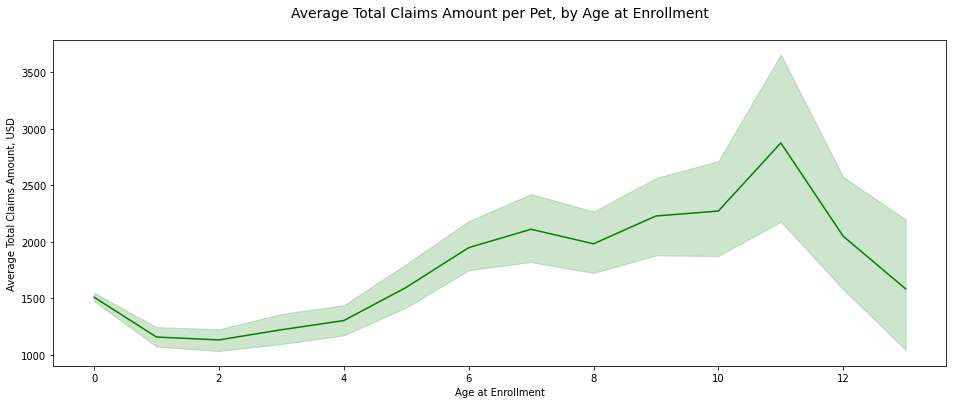

In [48]:
# Create a line plot showing total claims by Age
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.lineplot(x="AgeYr1", y="AmtClaimsTotal", data=df,
             color="Green", ci=95).set(xlabel="Age at Enrollment", ylabel="Average Total Claims Amount, USD")

# Add titles and display
plt.title("Average Total Claims Amount per Pet, by Age at Enrollment", y=1.05, fontsize=14)
# plt.suptitle("(Unfiltered Dataset)", y=0.95, x=0.513, fontsize=11)
plt.show()

The line plot confirms our intuition - that total claims amounts tend to rise with age. We can also see that the confidence interval expands with age as well, indicating an increase in variability as pets age. This also makes sense as we would expect that some pets stay relatively healthy in old age and some accumulate health issues.

An interesting observation in the plot above is that the rising claims average peaks around age 11 and then starts moving back down again. It's hard to say what that's about although it could have something to do with the different life expectancies for pet breeds.

Let's take a look at the distribution of total claims by age using a violin plot.

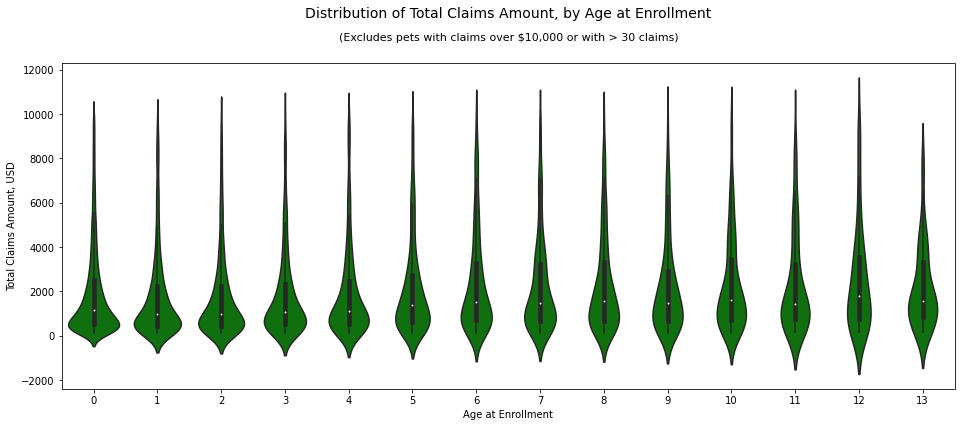

In [49]:
# Create a violin plot showing distribution of total claims based on year of enrollment
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.violinplot(x="AgeYr1", y="AmtClaimsTotal", data=claim_filter,
               color="Green").set(xlabel="Age at Enrollment", ylabel="Total Claims Amount, USD")

# Add titles and display
plt.title("Distribution of Total Claims Amount, by Age at Enrollment", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.show()

At a high level, the violin plot shows the distribution of total claims amounts changing with age. As age increases, we see the spread of total claims amounts increasing as well. That said, the details of the distribution are tough to make out in this view and it's tough to know if there is anything significant going on or not.

Before drawing final conclusions about age, let's take a look at the cumulative distributions by age and species.

In [50]:
# # Filter out outliers for number of claims and claim amounts
# claim_filter_low = df[(df.AmtClaimsTotal < 6000) & (df.AmtClaimsTotal > 100) &
#                  (df.NumClaimsTotal < 30) & (df.NumClaimsTotal > 0)]

# # Create a box plot showing claims amounts by age
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# sns.boxplot(x='AgeYr1', y='AmtClaimsTotal', data=claim_filter_low, color="Green",
#             ).set(ylabel="Total Claims Amount, USD", xlabel="Age at Enrollment")

# plt.title("Distribution of Total Claims Amount per Pet by Age of Enrollment", y=1.12, fontsize=14)
# plt.suptitle("(Excludes pets with total claims over $6000)", y=0.95, x=0.513)
# plt.show()

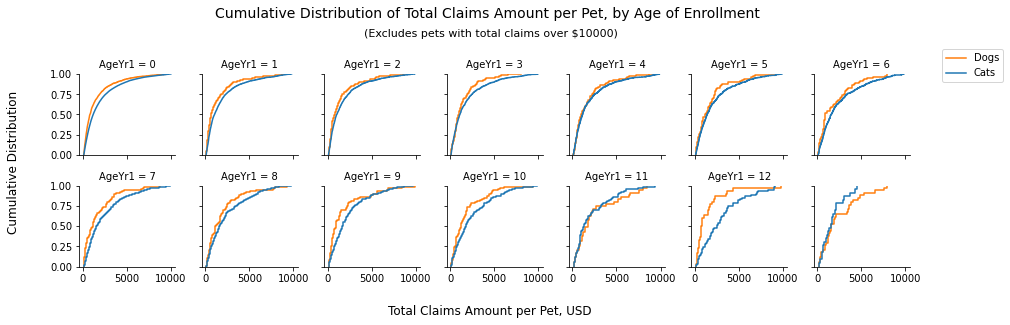

In [74]:
# Plot the ecdf of total claims by pet age at enrollment
g = sns.displot(claim_filter, x="AmtClaimsTotal", col="AgeYr1", col_wrap=7, hue="Species",
                kind="ecdf", height=1.8, legend=False) 
g.set_axis_labels("", "");

# Add titles, legend and display
plt.title("Cumulative Distribution of Total Claims Amount per Pet, by Age of Enrollment",
          y=3, x=-3.4, fontsize=14)
plt.suptitle("(Excludes pets with total claims over $10000)", y=1.08, x=0.513, fontsize=11)
g.fig.legend(labels=['Dogs', 'Cats'], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.gcf().text(0.4, -0.025, 'Total Claims Amount per Pet, USD', fontsize=12)
plt.gcf().text(-0.02, 0.3, 'Cumulative Distribution', fontsize=12, rotation=90)
plt.show()

Looking at the cumulative distributions, we see similar trends at every age. This view also supports the earlier observation that variability tends to increase with age.

In terms of species differences, we can see that at just about every age, dogs *tend* to have higher claims amounts, although the differences are very slight in most cases. At the oldest band of of ages - 11, 12, and 13 - the curves start to become more erratic, likely due to the fact that the number of pets in our data is very low in that range.

**Conclusions**
* Average total claims amounts tend to rise with age 
* The variability of total claims amounts also rises with age
* Age matters when it comes to claims amounts, but it doesn't follow a straighforward linear relationship

Next, let's take a look at enroll path to determine if this matters at all for our analysis.

### 3.6 Does enroll path tell us anything about pet claims?
Intuitively, it's probably safe to say no. But it could be the case that enroll path tells us something about the pet owners that translates into more or fewer claims. Let's start by looking at a count of pets in each category.

In [75]:
df.EnrollPath.value_counts()

Web      25486
Phone    23525
EB         989
Name: EnrollPath, dtype: int64

It looks like we have 3 possibilities, Web, Phone and EB. It's unclear what "EB" stands for, but luckliy that is a pretty small percentage of our data. The majority of pets were enrolled by either Web or Phone.

Since claims amounts are the focus of this project, let's see if there is any noticeable difference in the distributions of number or amount of claims related to enroll path. If not, it's probably safe for us to drop this column.

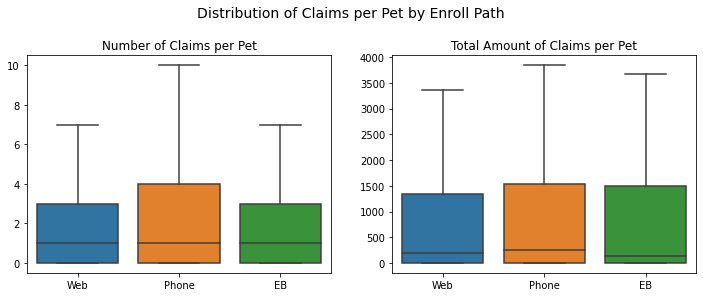

In [76]:
# Create box plots showing distribution of number and amount of claims by enroll path
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x="EnrollPath", y="NumClaimsTotal", data=df, ax=ax1,
            sym="").set(title = "Number of Claims per Pet", xlabel="", ylabel="")
sns.boxplot(x="EnrollPath", y="AmtClaimsTotal", data=df, ax=ax2,
            sym="").set(title = "Total Amount of Claims per Pet", xlabel="", ylabel="")

plt.suptitle("Distribution of Claims per Pet by Enroll Path", y=1.05, fontsize=14)
plt.show()

The distributions look very similar for all enroll paths which supports our original assertion that enroll path shouldn't have any significant impact on number or amount of claims.

Before moving on, let's look at a scatterplot for each and add a regression line. 

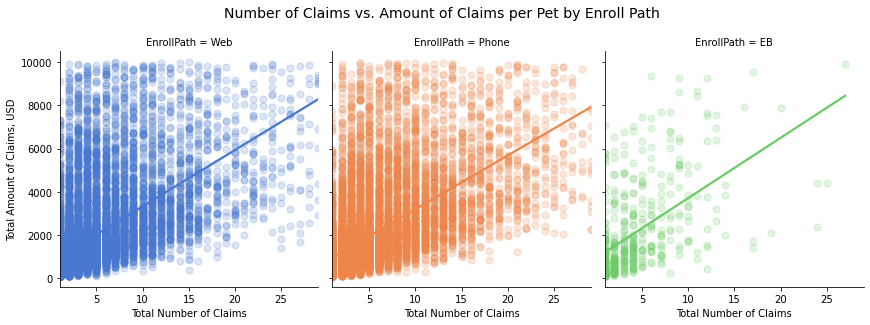

In [77]:
# Plot a regression model for each enroll path showing number of claims vs. amount of claims
g = sns.lmplot(x="NumClaimsTotal", y="AmtClaimsTotal", col="EnrollPath", hue="EnrollPath", data=claim_filter,
           ci=None, palette="muted", height=4, scatter_kws={"s": 50, "alpha": 0.2})
g.set_axis_labels("Total Number of Claims", "Total Amount of Claims, USD");

plt.suptitle("Number of Claims vs. Amount of Claims per Pet by Enroll Path", y=1.07, fontsize=14)
plt.show()

Adding the regression lines is a bit more helpful as we can see a similar trend across all three categories. For EB though, there's so little data that it's hard to trust the regression line especially as we get further out into the outliers.

While we do see some slight variation in the plots above, it doesn't seem to be significant enough to draw the conclusion that enroll path has an affect on number or amount of claims. Given this, we'll drop that column and move on.

In [78]:
# Drop EnrollPath
df = df.drop(columns=["EnrollPath"])

### 3.7 Do certain pet breeds have higher claims than others?
Again, the answer here seems like a pretty obvious "Yes", but let's see if we can prove that out in the data.

Let's start by getting a count of the number of unique breeds in each species.

In [213]:
# Get a counts of unique breeds in each species
df.groupby("Species").Breed.nunique()

Species
Cat     55
Dog    318
Name: Breed, dtype: int64

We have quite a high number of unique breeds in the data overall with dog breeds outnumbering cat breeds nearly 6 to 1 (similar to what we observed in out count of pets per breed).

To get started with our analysis, let's group our data by breed so we can get a count of pets and an average total claims amount for each breed.

In [214]:
# Group pets by breed and aggregate claims data columns
pets_by_breed = df.groupby(by=['Breed', 'Species']).agg({'PetId': ['count'],
                                                         'AmtClaimsTotal': ['mean']}).reset_index()
pets_by_breed.columns = ['Breed', 'Species', 'Count', 'AvgTotalClaims']

# Preview
pets_by_breed.head(10)

,Breed,Species,Count,AvgTotalClaims
0,Abyssinian,Cat,24,1462.780417
1,Affenpinscher,Dog,3,1746.190000
2,Afghan Hound,Dog,10,645.543000
3,Aidi,Dog,2,0.000000
4,Airedale Terrier,Dog,41,1338.705366
5,Akbash Dog,Dog,1,11383.600000
6,Akita,Dog,49,1217.911020
7,Alaskan Klee Kai,Dog,30,1510.666333
8,Alaskan Malamute,Dog,64,3096.346719
9,American Bandogge Mastiff,Dog,1,2295.070000


#### Initial Observations
Already we see a couple of problems with breed. First, it's clear there is a pretty large variance in the number of pets for each breed. Looking at the above, we see numbers ranging from 1 to 64. (And we already know from data wrangling that we have some breeds with over 3000 pets.) 

Second, due to this wide range, we have at least one breed with a very low count (Aidi - 1) with \$0 in total claims. Does that mean Aidi never have claims? Doubtful. On the flip side, we also see the opposite problem where certain breeds with low a low number of pets have a very high average claims amount (e.g., Akbash Dog). 

We'll need to address these issues somehow or else, we may just need to drop breed from the data. Let's continue on with the analysis to see what else we discover. We'll start by sorting the data to identify the breeds with the highest average claims amount.

In [216]:
# Sort data by average claims amount and view the top ten
pets_by_breed.sort_values("AvgTotalClaims", ascending=False).head(10)

,Breed,Species,Count,AvgTotalClaims
315,Selkirk Rex,Cat,1,25578.190000
55,Bergamasco Sheepdog,Dog,1,21981.270000
350,Tibetan Mastiff,Dog,2,19668.195000
5,Akbash Dog,Dog,1,11383.600000
19,American Mastiff,Dog,1,11064.570000
342,St Johns Waterdog,Dog,1,9868.480000
116,Colorpoint Shorthair,Cat,2,9806.425000
222,Mi Ki,Dog,6,7556.816667
267,Perro de Presa Canario,Dog,7,7225.331429
129,Dogue de Bordeaux,Dog,12,6343.498333


As suspected, we see the most expensive breed, Selkirk Rex, only includes data for one pet. And overall, the top ten is dominated by breeds with low pet counts. 

Next, let's filter the outlier breeds (average claims > \$5000) and take a look at a scatter plot of average total claims vs. the count of pets in each breed. To add some interest, we can color the plot by species.

We'll also plot a horizontal line showing the weighted average for total claims by breed. This will help to smooth our outlier values a bit more and hopefully provide a better picture as to the true mean value across all breeds. 

To arrive at this, we'll to the following:
1. Add a new column called *weighted_total* which we'll calculate as the *Count* of pets in a breed multiplied by the *average total claims* for the breed
2. Sum up the *weighted total* across all breeds and divide by the sum of the *Count* across all breeds

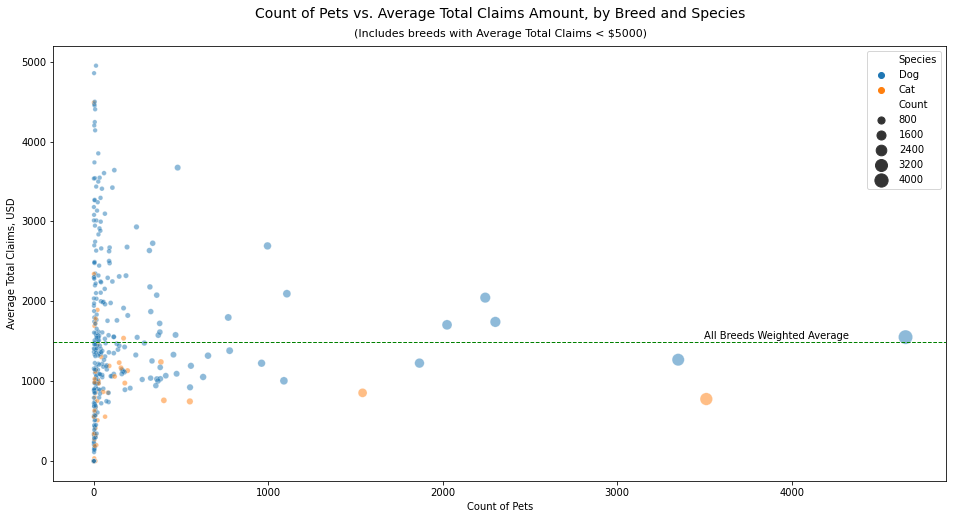

In [217]:
# Filter outliers to get a better view
filtered_pets = pets_by_breed[pets_by_breed.AvgTotalClaims < 5000]

# Create a scatterplot showing count of breed vs avg total claims
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.scatterplot(x="Count", y="AvgTotalClaims", data=filtered_pets, hue='Species', hue_order=['Dog', 'Cat'],
                alpha=0.5, size="Count", sizes=(20, 200)).set(xlabel="Count of Pets",
                                                              ylabel="Average Total Claims, USD")

# Calculate weighted average
pets_by_breed["weighted_total"] = pets_by_breed["Count"] * pets_by_breed["AvgTotalClaims"]
weighted_avg = pets_by_breed["weighted_total"].sum() / pets_by_breed["Count"].sum()

# Plot line showing the average for all pets
plt.axhline(weighted_avg, color='g', linestyle='dashed', linewidth=1)
plt.text(3500, 1525, "All Breeds Weighted Average")

# Add title and display plot
plt.title("Count of Pets vs. Average Total Claims Amount, by Breed and Species", y=1.05, fontsize=14)
plt.suptitle("(Includes breeds with Average Total Claims < $5000)",
             y=0.91, x=0.513, fontsize=11)

plt.legend(loc='upper right')
plt.show()

The above plot tells an interesting story in that we see a general trend that as the count of pets in a given breed goes up, there tendency for the average total claims amount to move toward the weighted average for all breeds combined.

Let's see how this looks when we break things down by species.

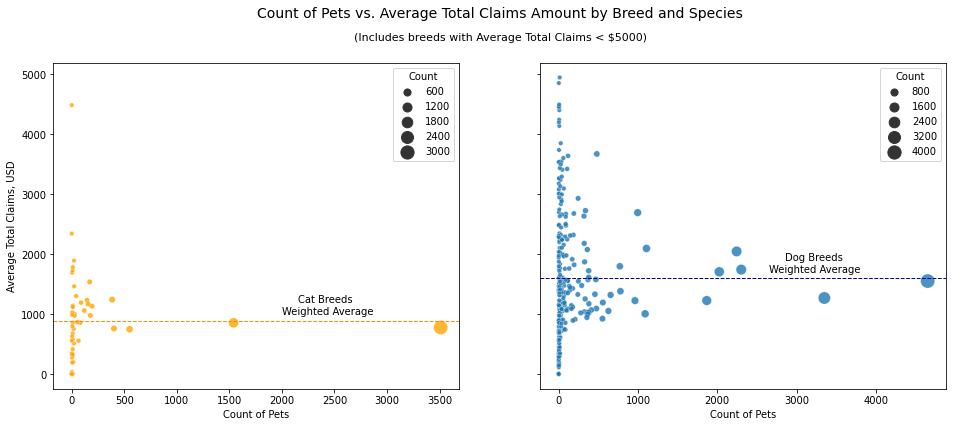

In [218]:
# Calculate weighted average by Species
cats_weighted_avg = (pets_by_breed[pets_by_breed.Species == 'Cat']["weighted_total"].sum()) / (
                     pets_by_breed[pets_by_breed.Species == 'Cat']["Count"].sum())
dogs_weighted_avg = (pets_by_breed[pets_by_breed.Species == 'Dog']["weighted_total"].sum()) / (
                     pets_by_breed[pets_by_breed.Species == 'Dog']["Count"].sum())

######
# TODO - Determine which average to use for hline. If using below, update the name of the 
# variables and plot titles.
######

# # Calculate weighted average by Species
# cats_weighted_avg = (pets_by_breed[pets_by_breed.Species == 'Cat']["AvgTotalClaims"].mean())
# dogs_weighted_avg = (pets_by_breed[pets_by_breed.Species == 'Dog']["AvgTotalClaims"].mean())

# Create a scatterplot showing count of breed vs avg total claims
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot cats and weighted average
sns.scatterplot(x="Count", y="AvgTotalClaims", data=filtered_pets[filtered_pets.Species == 'Cat'],
                size="Count", sizes=(20, 200), alpha=0.8, color='Orange',
                ax=ax1).set(title="", xlabel="Count of Pets", ylabel="Average Total Claims, USD")
ax1.axhline(cats_weighted_avg, color='darkorange', linestyle='dashed', linewidth=1)
ax1.text(2150, 1200, "Cat Breeds")
ax1.text(2000, 1000, "Weighted Average")

# Plot dogs and weighted average
sns.scatterplot(x="Count", y="AvgTotalClaims", data=filtered_pets[filtered_pets.Species == 'Dog'],
                size="Count", sizes=(20, 200), alpha=0.8,
                ax=ax2).set(title="", xlabel="Count of Pets", ylabel="Average Total Claims, USD")
ax2.axhline(dogs_weighted_avg, color='darkblue', linestyle='dashed', linewidth=1)
ax2.text(2850, 1900, "Dog Breeds")
ax2.text(2650, 1700, "Weighted Average")

# Add title and display plot
plt.title("Count of Pets vs. Average Total Claims Amount by Breed and Species", x=-0.1, y=1.12, fontsize=14)
plt.suptitle("(Includes breeds with Average Total Claims < $5000)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='upper right', title="Count")
plt.show()

# START HERE - Update observations 
* Average for cats is lower by about \$700
* As count of pets in breed goes up, there is a trend toward the weighted average

## Next steps
* Filter out breeds with pet counts under than a certain threshold and update to 'Other Cat' and 'Other Dog'
* Rerun above plots to check the result

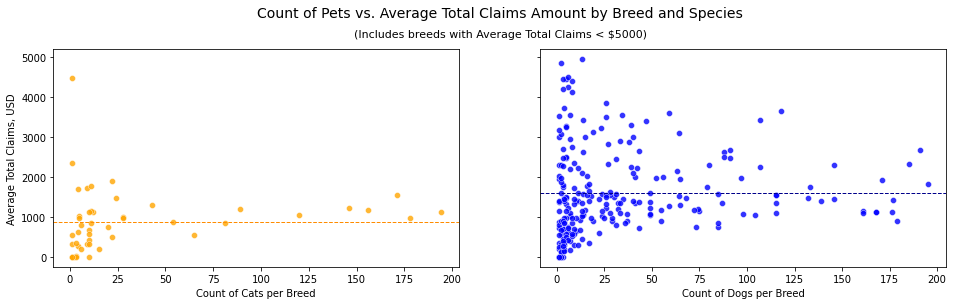

In [138]:
# Filter data to breeds with counts under 200
filtered_cats = filtered_pets[(filtered_pets.Species == 'Cat') & (filtered_pets.Count <= 200)]
filtered_dogs = filtered_pets[(filtered_pets.Species == 'Dog') & (filtered_pets.Count <= 200)]

# Create a scatterplot showing count of breed vs avg total claims
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Plot cats
sns.scatterplot(x="Count", y="AvgTotalClaims", data=filtered_cats, alpha=0.8, color='Orange',
                ax=ax1).set(title="", xlabel="Count of Cats per Breed", ylabel="Average Total Claims, USD")
ax1.axhline(cats_weighted_avg, color='darkorange', linestyle='dashed', linewidth=1)

# Plot dogs
sns.scatterplot(x="Count", y="AvgTotalClaims", data=filtered_dogs, alpha=0.8, color='Blue',
                ax=ax2).set(title="", xlabel="Count of Dogs per Breed", ylabel="Average Total Claims, USD")
ax2.axhline(dogs_weighted_avg, color='darkblue', linestyle='dashed', linewidth=1)

# Add title and display plot
plt.title("Count of Pets vs. Average Total Claims Amount by Breed and Species", x=-0.1, y=1.12, fontsize=14)
plt.suptitle("(Includes breeds with Average Total Claims < $5000)", y=0.95, x=0.513, fontsize=11)

plt.show()

# Update observations

For cats, we definitely see a strong trend toward the weighted average as the count of pets goes up above 25. We see a similar trend for dogs, but we don't see as much of a convergence toward the weighted average until we get to breeds with counts over 125.

It does seem to make sense that we should pick a threshold as our minimum count of pets per breed. Choosing this threshold is not as straightforward. As a starting point, let's set our threshold at 30 and see how that looks.

Here's a list of the steps we'll follow:
1. Set threshold and save a list of breeds with counts greater or equal to the threshold
2. Write a function to update the breed for a row based on whether or not it exists in the list from step 1
3. Create a copy of our original df and apply the function
4. Print out the before and after numbers for our count of unique breeds

In [166]:
# Set threshold
threshold = 50

# Preserve list of Breeds with count greater equal to the threshold
pet_breeds = pets_by_breed[pets_by_breed.Count >= threshold].Breed.tolist()

# Create function to update breed column based on threshold
def update_breed(row):
    if (row["Breed"] in pet_breeds):
        return row["Breed"]
    else:
        if (row["Species"] == 'Cat'):
            return 'Other Cat'
        else:
            return 'Other Dog'

# Print number of unique breeds before update
print("Number of unique breeds before: " + str(df.Breed.nunique()))

# Create copy of original df and apply function to update Breed
df_new = df.copy()
df_new["Breed"] = df_new.apply(update_breed, axis=1)
print("Number of unique breeds after: " + str(df_new.Breed.nunique()))

Number of unique breeds before: 373
Number of unique breeds after: 111


Now that we've filtered out breeds with a count of pets below our threshold, let's replot the data.

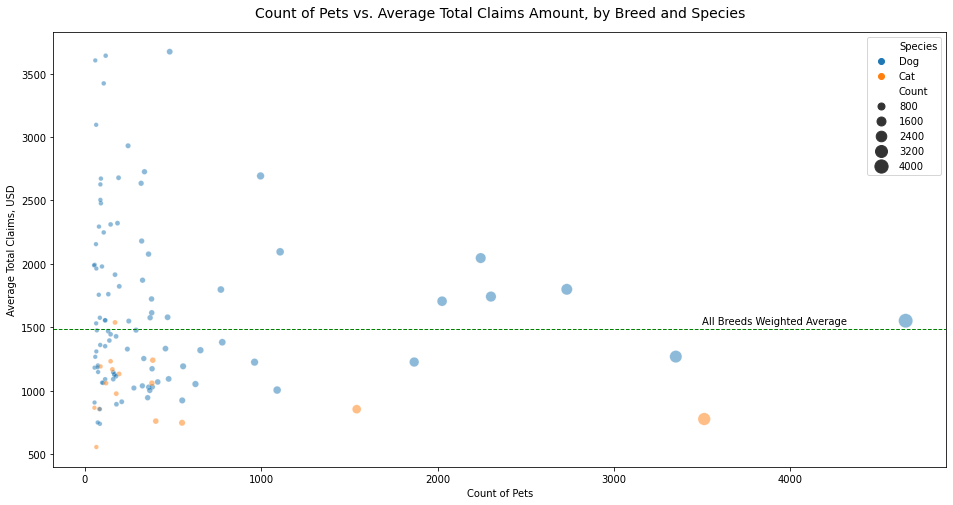

In [177]:
# Group pets by breed and aggregate claims data columns
pets_by_breed = df_new.groupby(by=['Breed', 'Species']).agg({'PetId': ['count'],
                                                         'AmtClaimsTotal': ['mean']}).reset_index()
pets_by_breed.columns = ['Breed', 'Species', 'Count', 'AvgTotalClaims']

# Calculate weighted average
pets_by_breed["weighted_total"] = pets_by_breed["Count"] * pets_by_breed["AvgTotalClaims"]
weighted_avg = pets_by_breed["weighted_total"].sum() / pets_by_breed["Count"].sum()

# Create a scatterplot showing count of breed vs avg total claims
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.scatterplot(x="Count", y="AvgTotalClaims", data=pets_by_breed, hue='Species', hue_order=['Dog', 'Cat'],
                alpha=0.5, size="Count", sizes=(20, 200)).set(xlabel="Count of Pets",
                                                              ylabel="Average Total Claims, USD")

# Plot line showing the average for all pets
plt.axhline(weighted_avg, color='g', linestyle='dashed', linewidth=1)
plt.text(3500, 1525, "All Breeds Weighted Average")

# Add title and display plot
plt.title("Count of Pets vs. Average Total Claims Amount, by Breed and Species", y=1.02, fontsize=14)
plt.suptitle("",
             y=0.91, x=0.513, fontsize=11)

plt.legend(loc='upper right')
plt.show()

In [162]:
# # Calculate weighted average by Species
# cats_weighted_avg = (pets_by_breed[pets_by_breed.Species == 'Cat']["weighted_total"].sum()) / (
#                      pets_by_breed[pets_by_breed.Species == 'Cat']["Count"].sum())
# dogs_weighted_avg = (pets_by_breed[pets_by_breed.Species == 'Dog']["weighted_total"].sum()) / (
#                      pets_by_breed[pets_by_breed.Species == 'Dog']["Count"].sum())

# # Create a scatterplot showing count of breed vs avg total claims
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# # Plot cats and weighted average
# sns.scatterplot(x="Count", y="AvgTotalClaims", data=pets_by_breed[pets_by_breed.Species == 'Cat'],
#                 size="Count", sizes=(20, 200), alpha=0.8, color='Orange',
#                 ax=ax1).set(title="", xlabel="Count of Pets", ylabel="Average Total Claims, USD")
# ax1.axhline(cats_weighted_avg, color='darkorange', linestyle='dashed', linewidth=1)
# ax1.text(2150, 1200, "Cat Breeds")
# ax1.text(2000, 1000, "Weighted Average")

# # Plot dogs and weighted average
# sns.scatterplot(x="Count", y="AvgTotalClaims", data=pets_by_breed[pets_by_breed.Species == 'Dog'],
#                 size="Count", sizes=(20, 200), alpha=0.8,
#                 ax=ax2).set(title="", xlabel="Count of Pets", ylabel="Average Total Claims, USD")
# ax2.axhline(dogs_weighted_avg, color='darkblue', linestyle='dashed', linewidth=1)
# ax2.text(2850, 1900, "Dog Breeds")
# ax2.text(2650, 1700, "Weighted Average")

# # Add title and display plot
# plt.title("Count of Pets vs. Average Total Claims Amount by Breed and Species", x=-0.1, y=1.12, fontsize=14)
# plt.suptitle("(Includes breeds with Average Total Claims < $5000)", y=0.95, x=0.513, fontsize=11)
# plt.legend(loc='upper right', title="Count")
# plt.show()

# Update observations and conclusions on Breed
* should I compare breed Premium, deductible and total claims?

### 3.8 Is there any significant correlation between claims in year 2 and our other features?

So far we've observed the following...

# Update with summary of couple of key findings
But so far, we haven't observed a strong connection between any of our features and our planned target (i.e., the amount of claims in year 2). Let's see if we can verify that finding by looking at a correlation matrix.

First we'll filter down to a subset of our features that we are likely to include in our predictive model and then we can calculate correlations and plot the result in a heatmap.

In [180]:
# Filter data by species
cats = df_new[df_new.Species == 'Cat']
dogs = df_new[df_new.Species == 'Dog']

# Filter species dfs down the a subset of features
cols = ['Premium', 'Deductible', 'AgeYr1', 'YoungAge', 'MixedBreed', 'AmtClaimsYr1',
             'AvgClaimsYr1', 'NumClaimsYr1', 'AmtClaimsYr2']
cats_filtered = cats[cols]
dogs_filtered = dogs[cols]

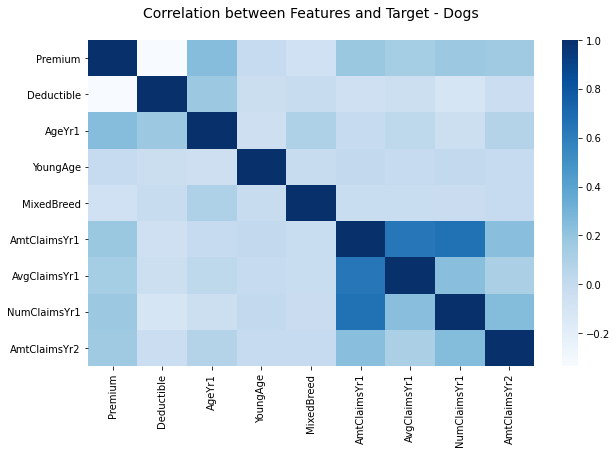

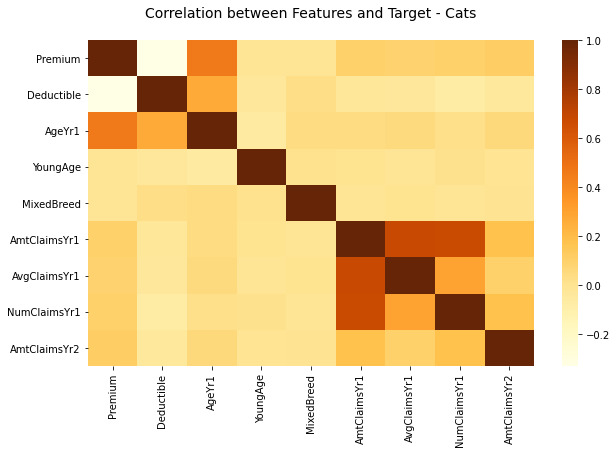

In [195]:
# Create correlation matrices
cats_corr = cats_filtered.corr()
dogs_corr = dogs_filtered.corr()

# Plot the corresponding heatmaps
plt.figure(figsize=(10,6))
_ = sns.heatmap(dogs_corr, cmap="Blues")
plt.title("Correlation between Features and Target - Dogs", y=1.05, fontsize=14)
plt.show()

plt.figure(figsize=(10,6))
_ = sns.heatmap(cats_corr, cmap="YlOrBr")
plt.title("Correlation between Features and Target - Cats", y=1.05, fontsize=14)
plt.show()

# Add observations about correlation
* Conclusions about correlation matrix

### 3.9 Principal Components Analysis
As noted, we don't see much correlation between our our current features and the amount of claims in year 2. 

In [201]:
# Filter df down the a subset of features
cols = ['Breed', 'Premium', 'Deductible', 'AgeYr1', 'YoungAge', 'MixedBreed', 'AmtClaimsYr1',
             'AvgClaimsYr1', 'NumClaimsYr1', 'AmtClaimsYr2']

#Create a new dataframe and set the index to Breed
df_new_scale = df_new[cols].set_index('Breed')

#Save the breed labels
df_new_index = df_new_scale.index

#Save the column names 
df_new_columns = df_new_scale.columns
df_new_scale.head()

,Premium,Deductible,AgeYr1,YoungAge,MixedBreed,AmtClaimsYr1,AvgClaimsYr1,NumClaimsYr1,AmtClaimsYr2
Breed,,,,,,,,,
Other Dog,84.54,200,3,0,0,0.00,0.000000,0,1242.00
Yorkiepoo,50.33,500,0,0,0,0.00,0.000000,0,0.00
Mixed Breed Medium,74.00,500,0,0,1,640.63,213.543333,3,1187.68
Labrador Retriever,57.54,500,0,0,0,0.00,0.000000,0,0.00
French Bulldog,60.69,700,0,0,0,7212.25,801.361111,9,168.75


In [202]:
df_new_scale = scale(df_new_scale)

In [203]:
#Create a new dataframe using saved column names
df_new_scaled_df = pd.DataFrame(df_new_scale, columns=df_new_columns)
df_new_scaled_df.head()

,Premium,Deductible,AgeYr1,YoungAge,MixedBreed,AmtClaimsYr1,AvgClaimsYr1,NumClaimsYr1,AmtClaimsYr2
0,0.601961,-0.984882,0.637317,-0.085517,-0.586650,-0.367817,-0.434252,-0.493220,0.245274
1,-0.400734,0.016632,-0.553989,-0.085517,-0.586650,-0.367817,-0.434252,-0.493220,-0.308511
2,0.293034,0.016632,-0.553989,-0.085517,1.704594,-0.072352,-0.019677,0.398528,0.221054
3,-0.189409,0.016632,-0.553989,-0.085517,-0.586650,-0.367817,-0.434252,-0.493220,-0.308511
4,-0.097082,0.684309,-0.553989,-0.085517,-0.586650,2.958539,1.121516,2.182023,-0.233268


In [204]:
# Verify the scaling
df_new_scaled_df.mean()

Premium         1.825895e-16
Deductible     -4.040146e-16
AgeYr1         -3.863987e-15
YoungAge        2.160488e-16
MixedBreed      5.364198e-16
AmtClaimsYr1   -6.405076e-16
AvgClaimsYr1   -3.634804e-16
NumClaimsYr1    1.316611e-15
AmtClaimsYr2   -1.423472e-15
dtype: float64

In [206]:
# Verify scaled std
df_new_scaled_df.std(ddof=0)

Premium         1.0
Deductible      1.0
AgeYr1          1.0
YoungAge        1.0
MixedBreed      1.0
AmtClaimsYr1    1.0
AvgClaimsYr1    1.0
NumClaimsYr1    1.0
AmtClaimsYr2    1.0
dtype: float64

In [207]:
pets_pca = PCA().fit(df_new_scale)

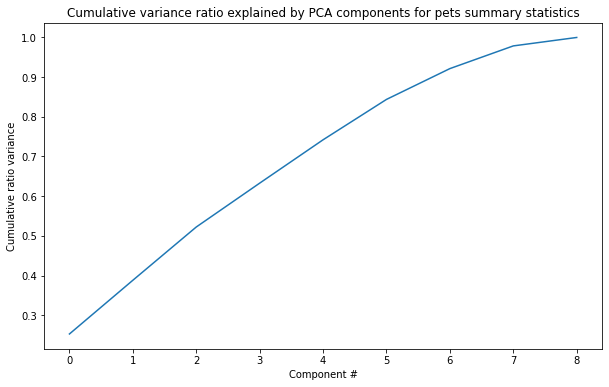

In [208]:
# Plot the result
plt.subplots(figsize=(10, 6))
plt.plot(pets_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for pets summary statistics')
plt.show()

## 4 Summary and Conclusions


* Overall summary of and key takeaways
* Clean up data for next step and write to new file
* Initial thoughts about pre-processing and/or predictive model